# Package Detect

In [2]:
!pip install roboflow python-dotenv pycocotools

## 1. Data Collection
We will use a dataset published in Roboflow Universe in COCO JSON Format

[Package Dataset](https://universe.roboflow.com/ammar-s/packages-v4)

In [3]:
from roboflow import Roboflow
from dotenv import load_dotenv
import os

load_dotenv()
KEY=os.getenv("ROBOFLOW_KEY")
rf = Roboflow(api_key=KEY)
project = rf.workspace("ammar-s").project("packages-v4")
version = project.version(7)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


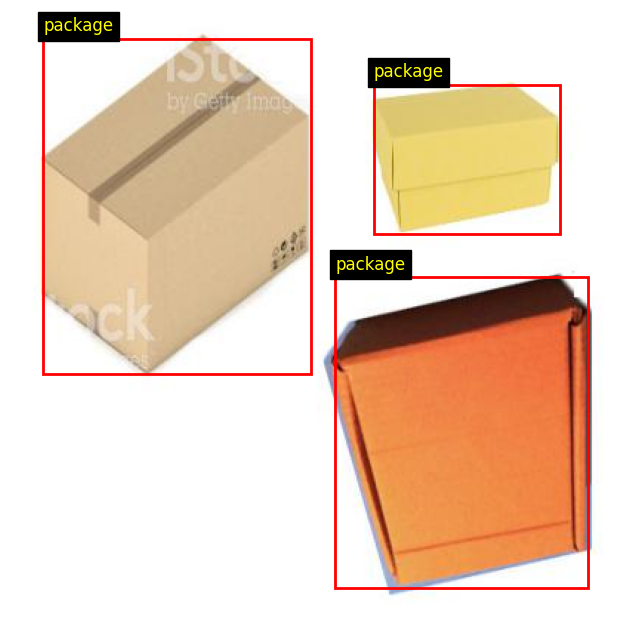

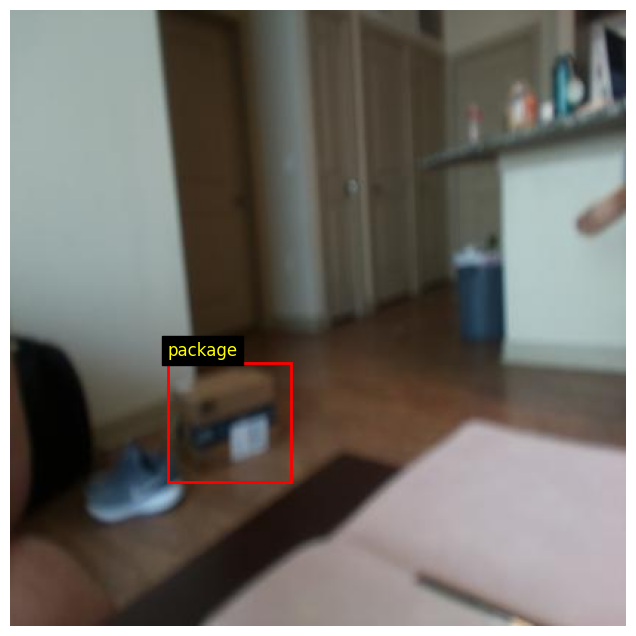

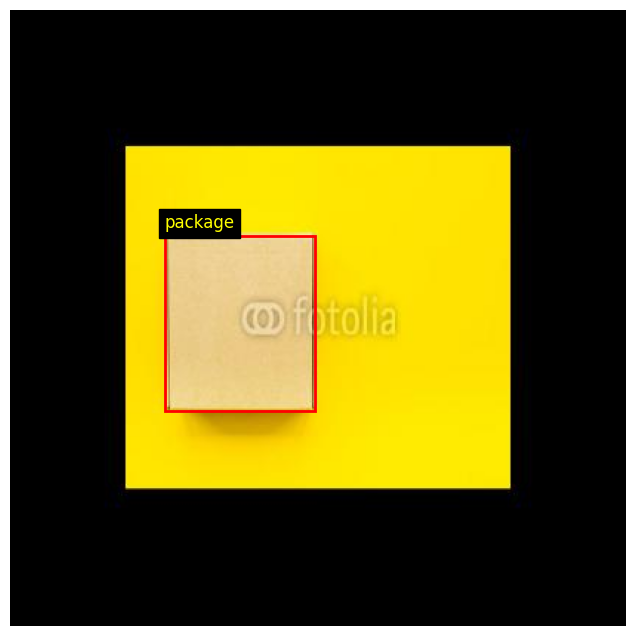

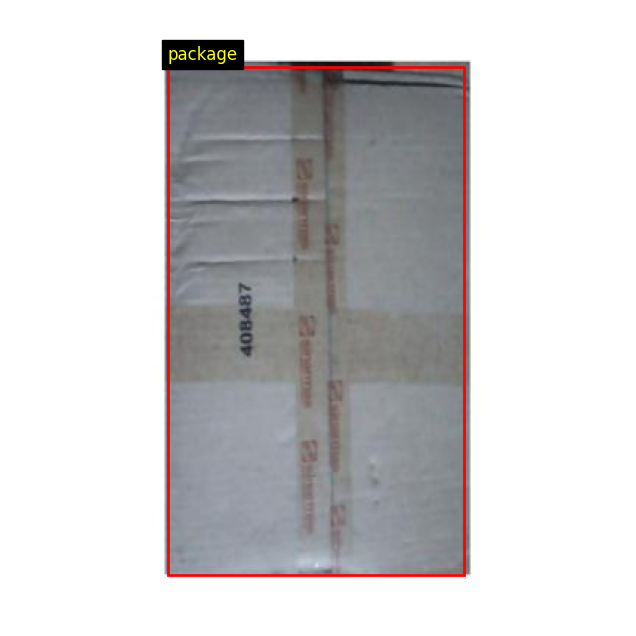

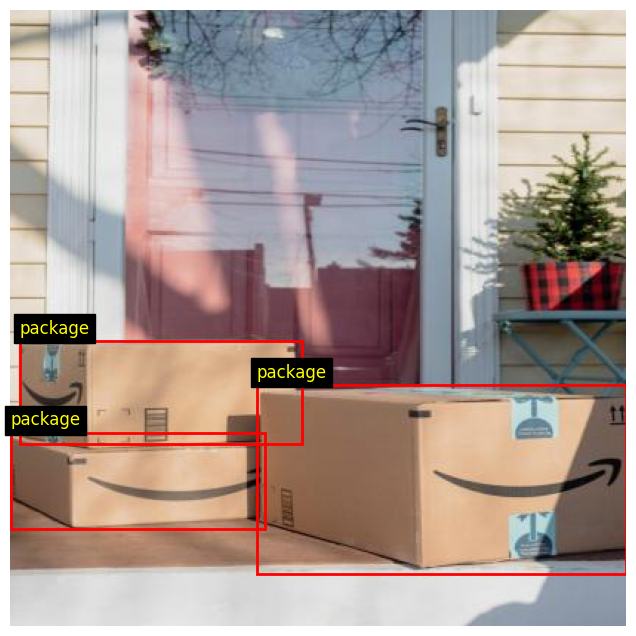

In [4]:
import os
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import matplotlib.patches as patches

# Paths
dataset_dir = dataset.location
images_dir = os.path.join(dataset_dir, "train")
annotations_file = os.path.join(images_dir, "_annotations.coco.json")

# Load COCO annotations
coco = COCO(annotations_file)

# Get category names
categories = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}

# Display first 5 images with bounding boxes
img_ids = coco.getImgIds()[:5]

for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(images_dir, img_info['file_name'])

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Plot image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    # Draw bounding boxes and labels
    for ann in anns:
        x, y, w, h = ann['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        cat_name = categories[ann['category_id']]
        ax.text(x, y - 5, cat_name, color='yellow', fontsize=12, backgroundcolor='black')

    plt.axis('off')
    plt.show()

## 2. Model Selection

For model Selection we will start with explorig with RF-DETR, which can be use as real time detector and exceed 60 AP on the Microsoft COCO object detection benchmark

References:
- [Roboflow github Repo](https://github.com/roboflow/rf-detr?tab=readme-ov-file)
- [Roboflow finetuning guide](https://rfdetr.roboflow.com/learn/train/#fine-tuning)

In [5]:
!pip install rfdetr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 14.6 MB/s eta 0:00:00
Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (180 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.2 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl

## 3. Fine tunning Pipeline

In [6]:
from rfdetr import RFDETRBase

model = RFDETRBase()

model.train(
    dataset_dir=dataset.location,
    epochs=10,
    batch_size=16,
    grad_accum_steps=1,
    lr=1e-4,
    early_stopping=True,
)

rf-detr-base.pth: 100%|██████████| 355M/355M [00:03<00:00, 110MiB/s]


Loading pretrain weights
TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=2, grad_accum_steps=1, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=16, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256

Epoch: [0]  [ 0/19]  eta: 0:01:52  lr: 0.000100  class_error: 7.20  loss: 8.3275 (8.3275)  loss_ce: 1.2492 (1.2492)  loss_bbox: 0.3586 (0.3586)  loss_giou: 0.3845 (0.3845)  loss_ce_0: 1.2935 (1.2935)  loss_bbox_0: 0.4351 (0.4351)  loss_giou_0: 0.3966 (0.3966)  loss_ce_1: 1.3049 (1.3049)  loss_bbox_1: 0.3250 (0.3250)  loss_giou_1: 0.3945 (0.3945)  loss_ce_enc: 1.2898 (1.2898)  loss_bbox_enc: 0.4525 (0.4525)  loss_giou_enc: 0.4433 (0.4433)  loss_ce_unscaled: 1.2492 (1.2492)  class_error_unscaled: 7.1960 (7.1960)  loss_bbox_unscaled: 0.0717 (0.0717)  loss_giou_unscaled: 0.1923 (0.1923)  cardinality_error_unscaled: 3.5000 (3.5000)  loss_ce_0_unscaled: 1.2935 (1.2935)  loss_bbox_0_unscaled: 0.0870 (0.0870)  loss_giou_0_unscaled: 0.1983 (0.1983)  cardinality_error_0_unscaled: 1.9375 (1.9375)  loss_ce_1_unscaled: 1.3049 (1.3049)  loss_bbox_1_unscaled: 0.0650 (0.0650)  loss_giou_1_unscaled: 0.1973 (0.1973)  cardinality_error_1_unscaled: 1.9375 (1.9375)  loss_ce_enc_unscaled: 1.2898 (1.2898)  l

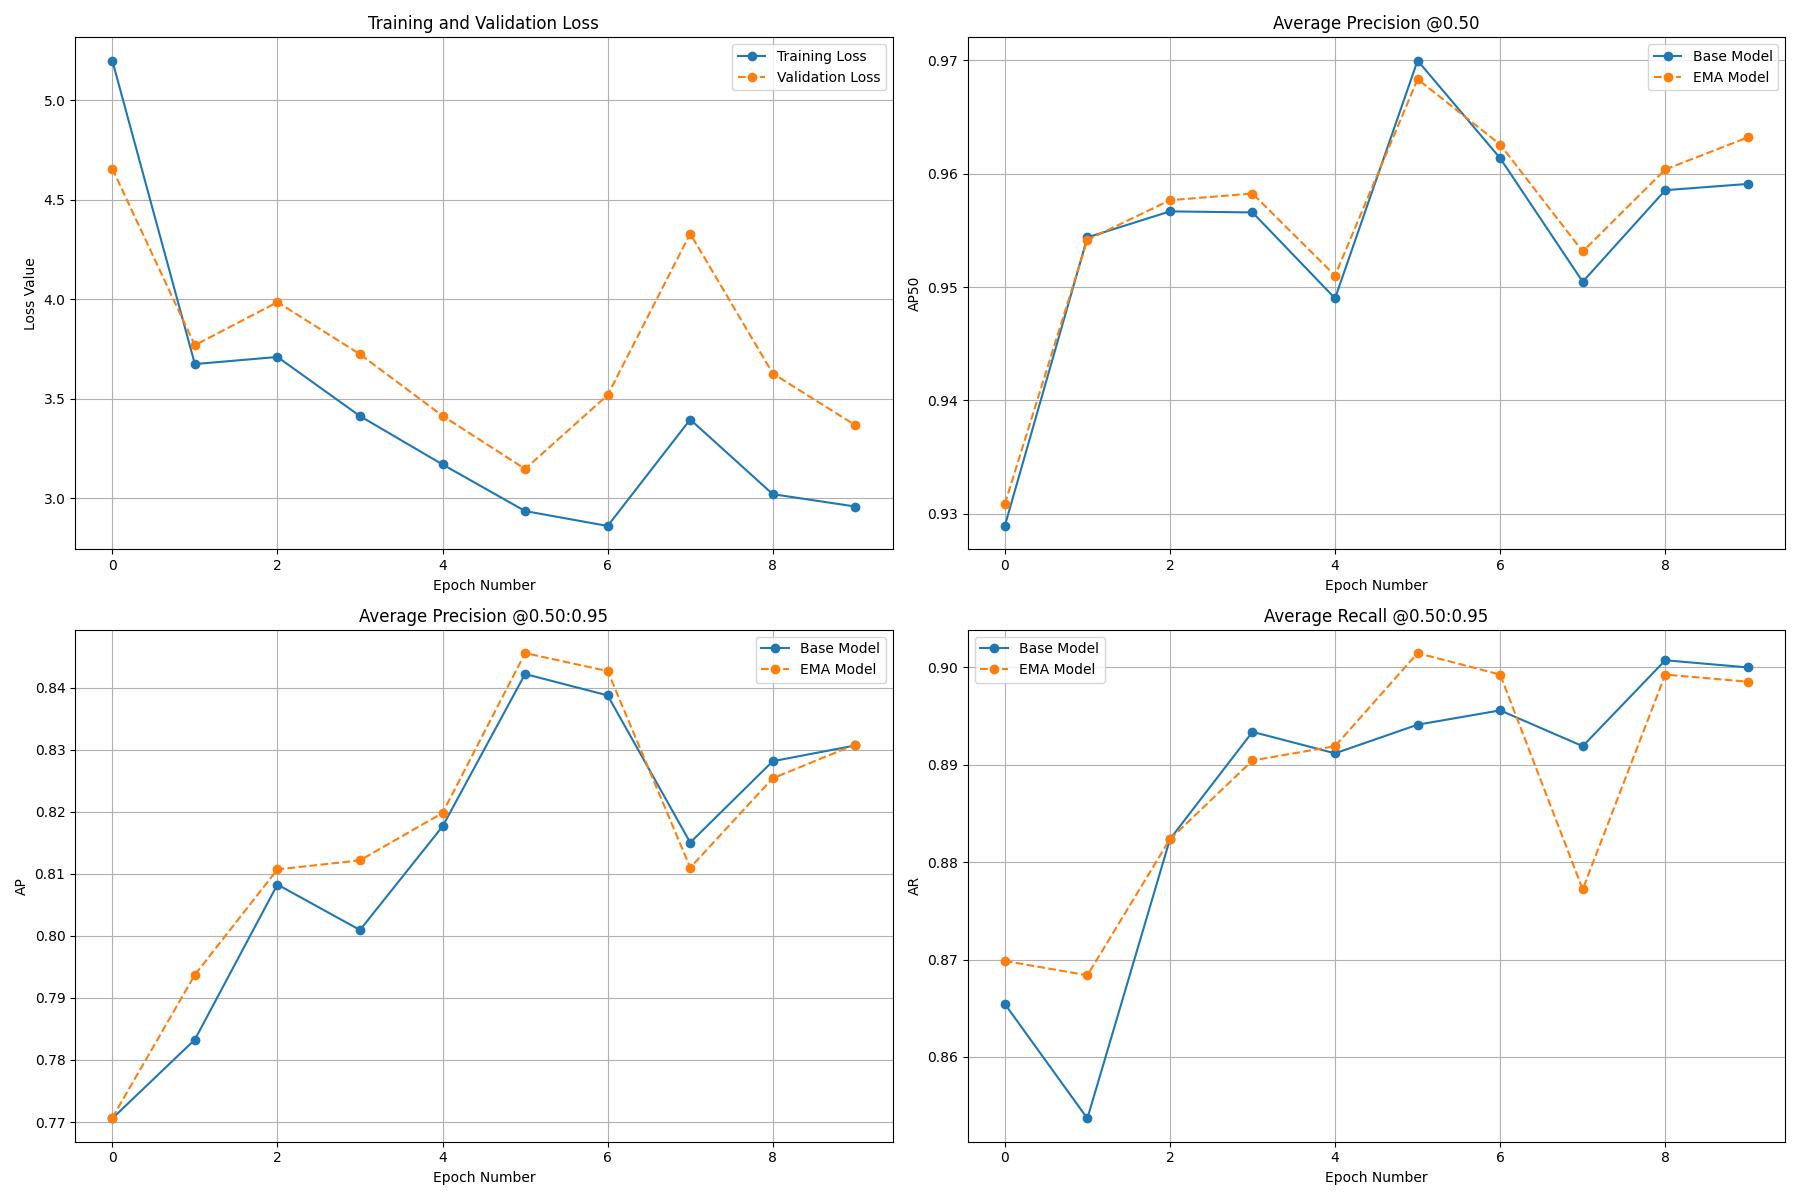

In [10]:
from PIL import Image

Image.open("./output/metrics_plot.png")

In [21]:
!zip -r output.zip ./output

  adding: output/ (stored 0%)
  adding: output/metrics_plot.png (deflated 6%)
  adding: output/checkpoint_best_total.pth (deflated 8%)
  adding: output/results.json (deflated 74%)
  adding: output/log.txt (deflated 80%)
  adding: output/.ipynb_checkpoints/ (stored 0%)


In [24]:
from rfdetr import RFDETRBase
import os
import random

Wa = "./output/checkpoint_best_total.pth"
images = os.listdir("./Packages-V4-7/test")
X = random.choice(images)
X = os.path.join("./Packages-V4-7/test", X)

model = RFDETRBase(pretrain_weights=Wa)

detections = model.predict(X)
print(detections)

Loading pretrain weights
Detections(xyxy=array([[ -0.64908504,   8.310322  , 290.14908   , 411.14444   ]],
      dtype=float32), mask=None, confidence=array([0.9687358], dtype=float32), class_id=array([1]), tracker_id=None, data={}, metadata={})


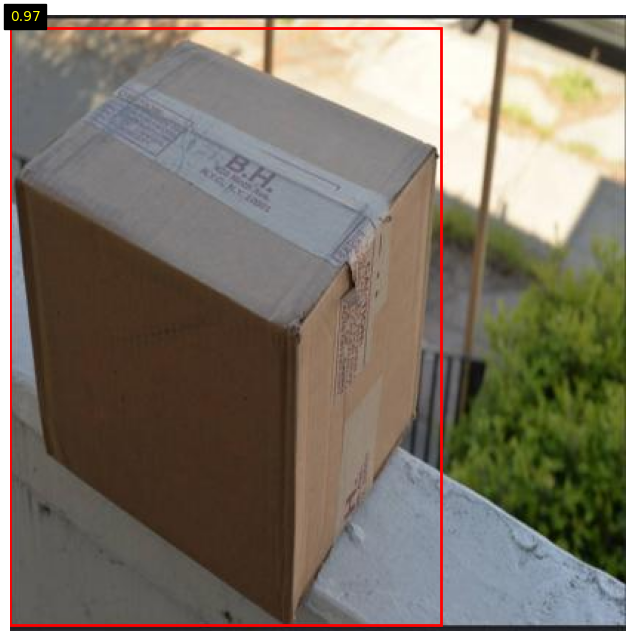

In [25]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_detections(img_path, detections):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    for box, score, cid in zip(detections.xyxy,
                               detections.confidence,
                               detections.class_id):
        x1, y1, x2, y2 = box
        ax.add_patch(
            patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                edgecolor="red",
                facecolor="none"
            )
        )
        ax.text(
            x1, y1 - 5,
            f"{float(score):.2f}",
            color="yellow",
            fontsize=10,
            backgroundcolor="black"
        )

    plt.axis("off")
    plt.show()


plot_detections(X, detections)


## 4. Evaluation of the modeL

In [5]:
from rfdetr import RFDETRBase
import torch

model = RFDETRBase(pretrain_weights="./output/checkpoint_best_total.pth")
model.optimize_for_inference(compile=False)

Loading pretrain weights


In [7]:
import supervision as sv
from PIL import Image
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision, Precision, Recall

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

targets = []
predictions = []
predictions2 = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.25).with_nms(threshold=0.5)
    detections2 = model.predict(image, threshold=0.5).with_nms(threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)
    predictions2.append(detections2)

map_metric = MeanAveragePrecision()
precision = Precision()
recall = Recall()
map_result = map_metric.update(predictions, targets).compute()
precision_result = precision.update(predictions, targets).compute()
recall_result = recall.update(predictions, targets).compute()
print("Threshold 0.25")
print(f"mAP@50: {map_result.map50}")
print(f"Precision: {precision_result.precision_at_50}")
print(f"Recall: {recall_result.recall_at_50}")


map_metric = MeanAveragePrecision()
precision = Precision()
recall = Recall()
map_result = map_metric.update(predictions2, targets).compute()
precision_result = precision.update(predictions2, targets).compute()
recall_result = recall.update(predictions2, targets).compute()
print("Threshold 0.50")
print(f"mAP@50: {map_result.map50}")
print(f"Precision: {precision_result.precision_at_50}")
print(f"Recall: {recall_result.recall_at_50}")

100%|██████████| 46/46 [00:06<00:00,  6.85it/s]


Threshold 0.25
mAP@50: 0.9729561444462412
Precision: 0.8701298701298701
Recall: 0.9852941176470589
Threshold 0.50
mAP@50: 0.9378509679326142
Precision: 0.9696969696969697
Recall: 0.9411764705882353


### Analysis
Note: Reference results from RoboFlow Universe [Dataset](https://universe.roboflow.com/ammar-s/packages-v4)

| Model                                      | mAP@50 | Precision | Recall |
| ------------------------------------------ | ------ | --------- | ------ |
| Packages-V4-7 Model                        | 96.5%  | 96.1%     | 91.1%  |
| Fine tune Model with RFDETRBase thresh @25 | 97.3%  | 87.0%     | 98.5%  |
| Fine tune Model with RFDETRBase thresh @50 | 93.7%  | 97.0%     | 94.1%  |


- **mAP:**  
  - RFDETR (0.25) slightly outperforms Packages-V4-7 Model   (97.3% vs 96.5%), showing it detects more objects overall.  
  - RFDETR (0.50) drops below Packages-V4-7 Model   (93.7%), reflecting fewer counted predictions.

- **Precision:**  
  - Packages-V4-7 Model is very precise (96.1%), better than RFDETR at low threshold (87.0%).  
  - Increasing RFDETR threshold to 0.50 raises precision to 97.0%, slightly above Packages-V4-7 Model  .

- **Recall:**  
  - RFDETR excels at recall (98.5% at 0.25), detecting almost all objects.  
  - Packages-V4-7 Model   has lower recall (91.1%), meaning some objects are missed.

**Conclusion:**  
- **RFDETR** is more flexible and recall-focused, outperforming Packages-V4-7 Model in detecting more objects at low threshold, but with more false positives.  
- Packages-V4-7 Model is more conservative and precision-focused, missing some objects but keeping false positives low.  
- Adjusting RFDETR confidence threshold allows tuning between **high recall (0.25)** and **high precision (0.50)** to meet different application needs.

## 5. Deployment